 Iniciando Sistema de Análisis Biomecánico...
 Verificando requisitos del sistema...
  SISTEMA DE ANÁLISIS BIOMECÁNICO PARA SALTO LARGO

Iniciando interfaz gráfica...
------------------------------------------------------------


2025-08-13 10:10:23,073 - INFO - Cámara inicializada: 1280x720 @ 30.0 FPS
2025-08-13 10:10:25,648 - INFO - Grabación de video iniciada: salto_largo_20250813_101025.mp4
2025-08-13 10:10:25,652 - INFO - Grabación visual iniciada
2025-08-13 10:10:25,653 - INFO - Simulación IMU iniciada
2025-08-13 10:10:39,030 - INFO - Video guardado: salto_largo_20250813_101025.mp4
2025-08-13 10:10:39,030 - INFO - Grabación visual detenida
2025-08-13 10:10:39,046 - INFO - Simulación IMU detenida



✅ Sistema finalizado correctamente.
Fin de la ejecución


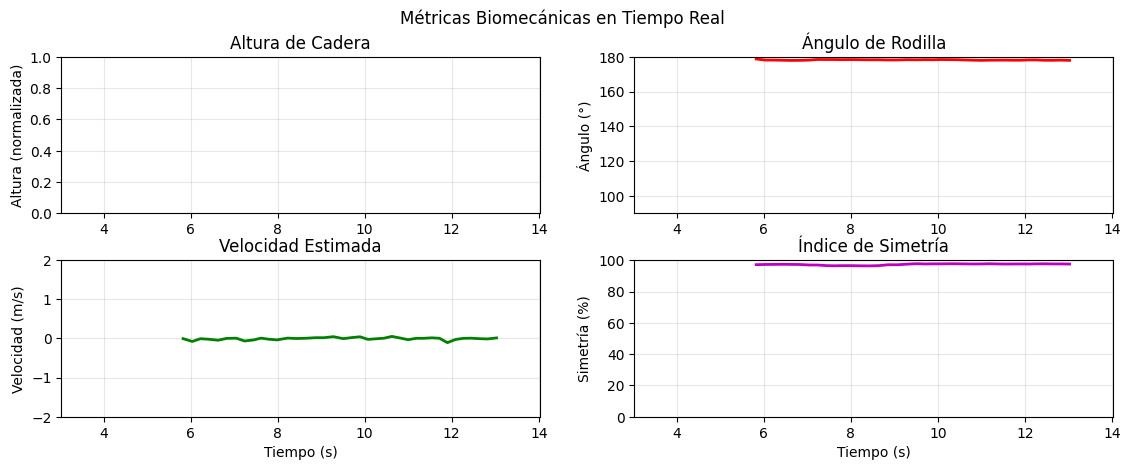

In [ ]:
"""
SISTEMA DE ANÁLISIS BIOMECÁNICO PARA SALTO LARGO
================================================================

Este sistema implementa una solución híbrida inercial-visual para el análisis 
técnico y físico del salto largo en deportistas. Combina:

1. ANÁLISIS VISUAL: Utiliza MediaPipe para detectar 33 puntos clave del cuerpo humano
2. SIMULACIÓN IMU: Simula 11 sensores inerciales distribuidos estratégicamente
3. ANÁLISIS BIOMECÁNICO: Calcula métricas específicas del salto largo en tiempo real
4. INTERFAZ GRÁFICA: Proporciona visualización y control del sistema

CARACTERÍSTICAS PRINCIPALES:
- Análisis en tiempo real de técnica de salto
- Cálculo de centro de masa corporal
- Medición de ángulos articulares críticos
- Evaluación de simetría bilateral
- Exportación de datos para análisis posterior

REQUISITOS TÉCNICOS:
- Python 3.8+
- OpenCV para captura de video
- MediaPipe para análisis postural
- Tkinter para interfaz gráfica
- Matplotlib para gráficos en tiempo real

Autor: Daniel Andres Ramirez Segura
Versión: 1.1
Fecha Creación: 01 Agosto 2025
Actualización: 12 Agosto 2025
"""

# Importación de librerías necesarias para el procesamiento de video, datos y visualización.
# cv2: Librería OpenCV para captura y manipulación de video desde la cámara.
import cv2
# np: NumPy para operaciones matemáticas y manejo de arrays numéricos, esencial para cálculos biomecánicos.
import numpy as np
# pd: Pandas para manejar datos en formato tabular, útil para exportar resultados a CSV.
import pandas as pd
# mp: MediaPipe, framework de Google para detección de poses humanas en tiempo real.
import mediapipe as mp
# threading: Para ejecutar procesos en hilos paralelos, como la captura de video sin bloquear la interfaz gráfica.
import threading
# queue: Para manejar colas de datos entre hilos, aunque en este código se usa deque para buffers.
import queue
# time: Para manejar tiempos, delays y timestamps en la captura de datos.
import time
# datetime: Para generar timestamps y nombres de archivos basados en fechas.
from datetime import datetime
# json: Para exportar metadatos en formato JSON.
import json
# math: Para funciones matemáticas básicas, aunque aquí se usa más NumPy.
import math
# deque: Estructura de cola doblemente terminada de collections, usada para buffers circulares de datos (eficiente en memoria).
from collections import deque
# logging: Para registrar eventos, errores y mensajes del sistema de manera estructurada.
import logging
# tk: Tkinter, librería estándar de Python para crear interfaces gráficas de usuario (GUI).
import tkinter as tk
# ttk, filedialog, messagebox: Componentes avanzados de Tkinter para widgets estilizados, diálogos de archivos y mensajes.
from tkinter import ttk, filedialog, messagebox
# plt: Matplotlib para generar gráficos y visualizaciones de datos en tiempo real.
import matplotlib.pyplot as plt
# FigureCanvasTkAgg: Backend para integrar gráficos de Matplotlib en Tkinter.
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
# FuncAnimation: Para animar gráficos en tiempo real, aunque aquí se actualizan manualmente.
from matplotlib.animation import FuncAnimation
# os: Para operaciones del sistema operativo, como manejo de paths (aunque no se usa explícitamente aquí).
import os
# Image, ImageTk: De PIL (Pillow) para manejar y convertir imágenes para mostrar en Tkinter.
from PIL import Image, ImageTk
# warnings: Para suprimir advertencias innecesarias durante la ejecución.
import warnings
# Ignorar todas las advertencias para una ejecución más limpia (no recomendado en producción, pero útil para depuración).
warnings.filterwarnings("ignore")

# Configuración del sistema de logging para registrar eventos.
# Nivel INFO: Registra información general, errores y advertencias.
# Formato: Incluye timestamp, nivel y mensaje.
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# Obtener el logger principal para usar en todo el código.
logger = logging.getLogger(__name__)

# AÑADIR AL INICIO DEL ARCHIVO (después de los imports): Importa re para expresiones regulares usadas en validaciones.
import re
# Importa psutil para monitoreo de recursos del sistema (RAM, CPU).
import psutil  # pip install psutil
# Importa Path de pathlib para manejo de directorios y paths de archivos de manera portable.
from pathlib import Path


# =============================================================================
# CLASE PRINCIPAL: ADQUISICIÓN DE DATOS VISUALES
# =============================================================================

class AdquisicionDataCamara:
    """
    CLASE PARA ADQUISICIÓN Y PROCESAMIENTO DE DATOS VISUALES
    
    Esta clase es el núcleo del análisis visual del sistema. Se encarga de:
    - Capturar video desde la cámara del computador
    - Procesar cada frame con MediaPipe para detectar poses humanas
    - Calcular métricas biomecánicas específicas del salto largo
    - Almacenar datos en buffers circulares para análisis en tiempo real
    
    FUNCIONAMIENTO:
    1. Inicializa la cámara con resolución y FPS específicos
    2. Cada frame capturado se procesa con MediaPipe
    3. Se extraen 33 puntos clave del cuerpo humano
    4. Se calculan métricas biomecánicas derivadas
    5. Los datos se almacenan para análisis posterior

    Jerarquía: Esta clase es independiente pero se integra con la interfaz gráfica (Interfaz_Biomecanica) 
    para control y visualización. Es el componente base para el análisis visual, y se ejecuta en un hilo 
    separado para no bloquear la GUI. End-users: Entiendan que esta clase maneja la cámara y procesa 
    los frames en tiempo real; si hay problemas con la cámara, revisen aquí.
    """

    # Constructor de la clase: Inicializa parámetros y componentes.
    # camera_id: ID de la cámara (por defecto 0, la cámara principal).
    # fps: Frames por segundo deseados.
    # resolution: Resolución del video (ancho, alto).
    def __init__(self, camera_id=0, fps=30, resolution=(1280, 720)):
        # Asigna el ID de la cámara.
        self.camera_id = camera_id
        # Asigna los FPS deseados.
        self.fps = fps
        # Asigna la resolución deseada.
        self.resolution = resolution
        # Bandera para indicar si se está grabando.
        self.is_recording = False
        # Bandera para mostrar previsualización de video.
        self.show_preview = True
        # Objeto para escribir video (inicialmente None).
        self.video_writer = None
        # Nombre del archivo de video (inicialmente None).
        self.video_filename = None
        # Frame actual procesado.
        self.current_frame = None
        # Carga el módulo de pose de MediaPipe.
        self.mp_pose = mp.solutions.pose
        # Carga el módulo de dibujo de MediaPipe para visualizar landmarks.
        self.mp_drawing = mp.solutions.drawing_utils
        # Inicializa el modelo de detección de pose con parámetros específicos:
        # - static_image_mode=False: Para video en tiempo real.
        # - model_complexity=2: Alta complejidad para precisión.
        # - enable_segmentation=False: No segmenta el fondo.
        # - min_detection_confidence=0.7: Confianza mínima para detección inicial.
        # - min_tracking_confidence=0.8: Confianza mínima para seguimiento.
        self.pose = self.mp_pose.Pose(
            static_image_mode=False,
            model_complexity=2,
            enable_segmentation=False,
            min_detection_confidence=0.7,
            min_tracking_confidence=0.8
        )
        # Buffer circular para datos visuales (máximo 5000 muestras para optimizar memoria).
        self.visual_data_buffer = deque(maxlen=5000)  # Reducido para mejor rendimiento
        # Buffer circular para frames procesados (máximo 30 para previsualización).
        self.frame_buffer = deque(maxlen=30)  # Reducido para optimizar memoria
        # Llama al método para inicializar la cámara.
        self.iniciar_camara()

    # Método para inicializar la captura de video desde la cámara.
    def iniciar_camara(self):
        # Bloque try para manejar errores en la inicialización.
        try:
            # Crea el objeto de captura de video con el ID especificado.
            self.cap = cv2.VideoCapture(self.camera_id)
            # Verifica si la cámara se abrió correctamente.
            if not self.cap.isOpened():
                # Lanza excepción si no se puede abrir.
                raise Exception(f"No se puede abrir la cámara {self.camera_id}")
            # Configura el ancho del frame.
            self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, self.resolution[0])
            # Configura el alto del frame.
            self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, self.resolution[1])
            # Configura los FPS deseados.
            self.cap.set(cv2.CAP_PROP_FPS, self.fps)
            # Configura el buffer de la cámara a 1 para minimizar latencia.
            self.cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)
            # Obtiene los FPS reales configurados.
            actual_fps = self.cap.get(cv2.CAP_PROP_FPS)
            # Obtiene el ancho real.
            actual_width = int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            # Obtiene el alto real.
            actual_height = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            # Registra información sobre la configuración real de la cámara.
            logger.info(f"Cámara inicializada: {actual_width}x{actual_height} @ {actual_fps} FPS")
        # Maneja excepciones en la inicialización.
        except Exception as e:
            # Registra el error.
            logger.error(f"Error inicializando cámara: {e}")
            # Relanza la excepción para manejo superior.
            raise

    # Método para procesar un frame individual con MediaPipe.
    def procesar_frame_mediapipe(self, frame):
        # Bloque try para manejar errores en el procesamiento.
        try:
            # Copia el frame original para modificaciones.
            self.current_frame = frame.copy()
            # Si se está grabando video y el writer está abierto:
            if self.video_writer and self.video_writer.isOpened():
                # Convierte el frame a RGB (MediaPipe requiere RGB).
                rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                # Procesa el frame con el modelo de pose.
                results = self.pose.process(rgb_frame)
                # Si se detectan landmarks:
                if results.pose_landmarks:
                    # Dibuja los landmarks y conexiones en el frame para el video grabado.
                    self.mp_drawing.draw_landmarks(
                        self.current_frame,
                        results.pose_landmarks,
                        self.mp_pose.POSE_CONNECTIONS,
                        landmark_drawing_spec=self.mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
                        connection_drawing_spec=self.mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2)
                    )
                # Escribe el frame procesado en el video.
                self.video_writer.write(self.current_frame)
            # Convierte el frame a RGB para procesamiento.
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Procesa el frame con MediaPipe para obtener landmarks.
            results = self.pose.process(rgb_frame)
            # Diccionario para almacenar datos de landmarks.
            landmarks_data = {}
            # Si se detectan landmarks:
            if results.pose_landmarks:
                # Obtiene la lista de landmarks.
                landmarks = results.pose_landmarks.landmark
                # Itera sobre los 33 landmarks estándar de MediaPipe.
                for idx, landmark in enumerate(landmarks):
                    # Almacena coordenada X normalizada.
                    landmarks_data[f'landmark_{idx}_x'] = landmark.x
                    # Almacena coordenada Y normalizada.
                    landmarks_data[f'landmark_{idx}_y'] = landmark.y
                    # Almacena coordenada Z relativa.
                    landmarks_data[f'landmark_{idx}_z'] = landmark.z
                    # Almacena visibilidad (confianza) del landmark.
                    landmarks_data[f'landmark_{idx}_visibility'] = landmark.visibility
                # Calcula métricas biomecánicas a partir de los landmarks.
                bio_metrics = self.calcular_metricas_biomecanicas(landmarks)
                # Actualiza el diccionario con las métricas biomecánicas.
                landmarks_data.update(bio_metrics)
                # Calcula métricas de calidad de la detección.
                quality_metrics = self.calcular_metricas_de_calidad(landmarks)
                # Actualiza el diccionario con métricas de calidad.
                landmarks_data.update(quality_metrics)
                # Si se debe mostrar previsualización:
                if self.show_preview:
                    # Dibuja landmarks en el frame actual para visualización.
                    self.mp_drawing.draw_landmarks(
                        self.current_frame,
                        results.pose_landmarks,
                        self.mp_pose.POSE_CONNECTIONS,
                        landmark_drawing_spec=self.mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
                        connection_drawing_spec=self.mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2)
                    )

                        # Dibuja el centro de masa si está calculado
                    if 'center_of_mass_x' in bio_metrics and 'center_of_mass_y' in bio_metrics:
                        self.dibujar_centro_de_masa(self.current_frame, bio_metrics['center_of_mass_x'], bio_metrics['center_of_mass_y'])                
                    # Agrega el frame procesado al buffer.
                    self.frame_buffer.append(self.current_frame.copy())
            # Si no se detectan landmarks, usa valores vacíos.
            else:
                landmarks_data = self._get_empty_landmarks()
            # Retorna los datos procesados.
            return landmarks_data
        # Maneja excepciones en el procesamiento.
        except Exception as e:
            # Registra el error.
            logger.error(f"Error procesando frame: {e}")
            # Retorna datos vacíos en caso de error.
            return self._get_empty_landmarks()

    # Método privado para obtener un diccionario de landmarks vacío con NaN.
    def _get_empty_landmarks(self):
        # Inicializa diccionario vacío.
        landmarks_data = {}
        # Para cada uno de los 33 landmarks:
        for idx in range(33):
            # Asigna NaN a coordenadas X, Y, Z.
            landmarks_data[f'landmark_{idx}_x'] = np.nan
            landmarks_data[f'landmark_{idx}_y'] = np.nan
            landmarks_data[f'landmark_{idx}_z'] = np.nan
            # Asigna 0 a visibilidad.
            landmarks_data[f'landmark_{idx}_visibility'] = 0.0
        # Agrega métricas biomecánicas vacías con NaN o 0.
        landmarks_data.update({
            'detection_confidence': 0.0,
            'detection_completeness': 0.0,
            'valid_landmarks': 0,
            'center_of_mass_x': np.nan,
            'center_of_mass_y': np.nan,
            'knee_angle_right': np.nan,
            'knee_angle_left': np.nan,
            'trunk_angle': np.nan,
            'hip_height': np.nan,
            'symmetry_index': 0.0,
            'velocity_x_estimated': 0.0
        })
        # Retorna el diccionario vacío.
        return landmarks_data

    # Método para calcular métricas biomecánicas específicas del salto largo.
    def calcular_metricas_biomecanicas(self, landmarks):
        # Diccionario para métricas.
        metrics = {}
        # Bloque try para manejar errores en cálculos.
        try:
            # Calcula centro de masa (COM) en X e Y.
            com_x, com_y = self.calcular_centro_de_masa(landmarks)
            # Almacena COM X.
            metrics['center_of_mass_x'] = com_x
            # Almacena COM Y.
            metrics['center_of_mass_y'] = com_y
            # Calcula ángulo de rodilla derecha usando landmarks 24,26,28 (cadera, rodilla, tobillo).
            knee_angle_r = self.calcular_angulo_articular(landmarks[24], landmarks[26], landmarks[28])
            # Almacena ángulo rodilla derecha.
            metrics['knee_angle_right'] = knee_angle_r
            # Calcula ángulo de rodilla izquierda usando landmarks 23,25,27.
            knee_angle_l = self.calcular_angulo_articular(landmarks[23], landmarks[25], landmarks[27])
            # Almacena ángulo rodilla izquierda.
            metrics['knee_angle_left'] = knee_angle_l
            # Calcula ángulo del tronco.
            trunk_angle = self.calcular_angulo_tronco(landmarks)
            # Almacena ángulo tronco.
            metrics['trunk_angle'] = trunk_angle
            # Calcula altura de cadera como promedio invertido de Y de caderas (normalizado).
            hip_height = (landmarks[23].y + landmarks[24].y) / 2
            # Almacena altura de cadera (1 - y para que más alto sea mayor valor).
            metrics['hip_height'] = 1.0 - hip_height
            # Calcula índice de simetría bilateral.
            symmetry_index = self.calcular_simetria_bilateral(landmarks)
            # Almacena simetría.
            metrics['symmetry_index'] = symmetry_index
            # Si hay datos previos en el buffer:
            if len(self.visual_data_buffer) > 0:
                # Obtiene COM X previo.
                prev_com_x = self.visual_data_buffer[-1].get('center_of_mass_x', com_x)
                # Calcula delta de tiempo basado en FPS.
                time_delta = 1.0 / self.fps
                # Estima velocidad en X como cambio en COM / delta tiempo.
                velocity_x = (com_x - prev_com_x) / time_delta if time_delta > 0 else 0
                # Almacena velocidad estimada.
                metrics['velocity_x_estimated'] = velocity_x
            # Si no hay datos previos, velocidad 0.
            else:
                metrics['velocity_x_estimated'] = 0.0
        # Maneja excepciones en cálculos.
        except Exception as e:
            # Registra advertencia.
            logger.warning(f"Error calculando métricas biomecánicas: {e}")
        # Retorna las métricas.
        return metrics

    def dibujar_centro_de_masa(self, frame, com_x, com_y):
            # Convierte coordenadas normalizadas a píxeles
            height, width = frame.shape[:2]
            com_x_px = int(com_x * width)
            com_y_px = int(com_y * height)
            # Dibuja punto en el centro de masa
            cv2.circle(frame, (com_x_px, com_y_px), 5, (0, 0, 255), -1)  # Punto rojo
            # Añade etiqueta
            cv2.putText(frame, "centro de masa", (com_x_px + 10, com_y_px - 10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Método para calcular el centro de masa aproximado usando pesos segmentales.
    def calcular_centro_de_masa(self, landmarks):
        # Diccionario de pesos relativos de segmentos corporales (aproximados para modelo biomecánico).
        segment_weights = {
            'head': 0.08, 'trunk': 0.50, 'arms': 0.10, 'thighs': 0.20, 'shanks': 0.12
        }
        # Calcula posición media de cabeza (landmark 0).
        head_x, head_y = landmarks[0].x, landmarks[0].y
        # Calcula posición media de tronco (promedio de hombros y caderas: 11,12,23,24).
        trunk_x = (landmarks[11].x + landmarks[12].x + landmarks[23].x + landmarks[24].x) / 4
        trunk_y = (landmarks[11].y + landmarks[12].y + landmarks[23].y + landmarks[24].y) / 4
        # Calcula posición media de brazos (promedio de codos y muñecas: 13,14,15,16).
        arms_x = (landmarks[13].x + landmarks[14].x + landmarks[15].x + landmarks[16].x) / 4
        arms_y = (landmarks[13].y + landmarks[14].y + landmarks[15].y + landmarks[16].y) / 4
        # Calcula posición media de muslos (promedio de rodillas: 25,26).
        thighs_x = (landmarks[25].x + landmarks[26].x) / 2
        thighs_y = (landmarks[25].y + landmarks[26].y) / 2
        # Calcula posición media de piernas inferiores (promedio de tobillos: 27,28).
        shanks_x = (landmarks[27].x + landmarks[28].x) / 2
        shanks_y = (landmarks[27].y + landmarks[28].y) / 2
        # Calcula COM ponderado en X sumando peso * posición.
        com_x = sum(segment_weights[k] * v for k, v in zip(segment_weights, [head_x, trunk_x, arms_x, thighs_x, shanks_x]))
        # Calcula COM ponderado en Y de manera similar.
        com_y = sum(segment_weights[k] * v for k, v in zip(segment_weights, [head_y, trunk_y, arms_y, thighs_y, shanks_y]))
        # Retorna COM X e Y.
        return com_x, com_y

    # Método para calcular ángulo entre tres puntos (usando ley del coseno).
    def calcular_angulo_articular(self, point1, point2, point3):
        # Bloque try para manejar errores.
        try:
            # Convierte puntos a arrays NumPy para vectores.
            a = np.array([point1.x, point1.y])
            b = np.array([point2.x, point2.y])
            c = np.array([point3.x, point3.y])
            # Vector BA.
            ba = a - b
            # Vector BC.
            bc = c - b
            # Calcula coseno del ángulo usando producto punto.
            cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
            # Limita el coseno entre -1 y 1 para evitar errores numéricos.
            cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
            # Calcula ángulo en radianes.
            angle = np.arccos(cosine_angle)
            # Convierte a grados y retorna.
            return np.degrees(angle)
        # En caso de error (ej. división por cero), retorna NaN.
        except:
            return np.nan

    # Método para calcular ángulo del tronco respecto a la vertical.
    def calcular_angulo_tronco(self, landmarks):
        # Bloque try para manejar errores.
        try:
            # Posición media de hombros (11,12).
            shoulder_mid_x = (landmarks[11].x + landmarks[12].x) / 2
            shoulder_mid_y = (landmarks[11].y + landmarks[12].y) / 2
            # Posición media de caderas (23,24).
            hip_mid_x = (landmarks[23].x + landmarks[24].x) / 2
            hip_mid_y = (landmarks[23].y + landmarks[24].y) / 2
            # Vector del tronco (de hombros a caderas).
            trunk_vector = np.array([hip_mid_x - shoulder_mid_x, hip_mid_y - shoulder_mid_y])
            # Vector vertical de referencia.
            vertical_vector = np.array([0, 1])
            # Calcula coseno del ángulo entre tronco y vertical.
            cosine_angle = np.dot(trunk_vector, vertical_vector) / (
                np.linalg.norm(trunk_vector) * np.linalg.norm(vertical_vector)
            )
            # Limita coseno.
            cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
            # Calcula ángulo en radianes.
            angle = np.arccos(cosine_angle)
            # Convierte a grados y retorna.
            return np.degrees(angle)
        # En caso de error, retorna NaN.
        except:
            return np.nan

    # Método para calcular simetría bilateral basada en posiciones de rodillas y tobillos.
    def calcular_simetria_bilateral(self, landmarks):
        # Bloque try para manejar errores.
        try:
            # Posición Y de rodilla izquierda (25).
            left_knee_y = landmarks[25].y
            # Posición Y de rodilla derecha (26).
            right_knee_y = landmarks[26].y
            # Posición Y de tobillo izquierdo (27).
            left_ankle_y = landmarks[27].y
            # Posición Y de tobillo derecho (28).
            right_ankle_y = landmarks[28].y
            # Diferencia absoluta en rodillas.
            knee_diff = abs(left_knee_y - right_knee_y)
            # Diferencia absoluta en tobillos.
            ankle_diff = abs(left_ankle_y - right_ankle_y)
            # Calcula simetría como 100 * (1 - promedio de diferencias).
            symmetry = 100 * (1 - (knee_diff + ankle_diff) / 2)
            # Retorna máximo entre 0 y simetría (para evitar negativos).
            return max(0, symmetry)
        # En caso de error, retorna 0.
        except:
            return 0.0

    # Método para calcular métricas de calidad de la detección.
    def calcular_metricas_de_calidad(self, landmarks):
        # Bloque try para manejar errores.
        try:
            # Landmarks clave para salto largo (hombros, caderas, rodillas, tobillos).
            key_landmarks = [11, 12, 13, 14, 23, 24, 25, 26, 27, 28]
            # Lista de visibilidades de landmarks clave.
            confidences = [landmarks[i].visibility for i in key_landmarks]
            # Confianza promedio.
            avg_confidence = np.mean(confidences)
            # Conteo de landmarks válidos (visibilidad > 0.5).
            valid_landmarks = sum(1 for conf in confidences if conf > 0.5)
            # Completitud como proporción de válidos.
            completeness = valid_landmarks / len(key_landmarks)
            # Retorna diccionario con métricas.
            return {
                'detection_confidence': avg_confidence,
                'detection_completeness': completeness,
                'valid_landmarks': valid_landmarks
            }
        # En caso de error, retorna valores cero.
        except:
            return {
                'detection_confidence': 0.0,
                'detection_completeness': 0.0,
                'valid_landmarks': 0
            }

    # Método principal para capturar datos visuales en un bucle mientras se graba.
    def capturar_datos_visuales(self):
        # Contador de frames.
        frame_count = 0
        # Timestamp de inicio.
        start_time = time.time()
        # Bucle mientras se esté grabando.
        while self.is_recording:
            # Lee un frame de la cámara.
            ret, frame = self.cap.read()
            # Si se leyó correctamente:
            if ret:
                # Obtiene timestamp actual.
                timestamp = time.time()
                # Procesa el frame con MediaPipe.
                landmarks_data = self.procesar_frame_mediapipe(frame)
                # Crea diccionario de muestra visual con timestamp y datos.
                visual_sample = {
                    'timestamp': timestamp,
                    'frame_number': frame_count,
                    'elapsed_time': timestamp - start_time,
                    **landmarks_data
                }
                # Agrega la muestra al buffer.
                self.visual_data_buffer.append(visual_sample)
                # Incrementa contador de frames.
                frame_count += 1
                # Calcula tiempo esperado para el próximo frame (para mantener FPS).
                expected_time = start_time + (frame_count / self.fps)
                # Tiempo actual.
                current_time = time.time()
                # Tiempo de sleep para sincronizar.
                sleep_time = expected_time - current_time
                # Si positivo, duerme.
                if sleep_time > 0:
                    time.sleep(sleep_time)
            # Si no se leyó frame, advierte y duerme brevemente.
            else:
                logger.warning("No se pudo capturar frame de la cámara")
                time.sleep(0.1)

    # Método para obtener el último frame del buffer.
    def obtener_ultimo_frame(self):
        # Si hay frames, retorna el último.
        if self.frame_buffer:
            return self.frame_buffer[-1]
        # Sino, None.
        return None

    # Método para comenzar la grabación en un hilo separado.
    def comenzar_grabacion(self):
        # Activa bandera de grabación.
        self.is_recording = True
        # Crea hilo para captura visual (daemon para que termine con el programa).
        self.hilo_visual = threading.Thread(target=self.capturar_datos_visuales, daemon=True)
        # Inicia el hilo.
        self.hilo_visual.start()
        # Registra inicio.
        logger.info("Grabación visual iniciada")

    # Método para detener la grabación.
    def detener_grabacion(self):
        # Desactiva bandera.
        self.is_recording = False
        # Si existe el hilo, espera a que termine (timeout 2s).
        if hasattr(self, 'hilo_visual'):
            self.hilo_visual.join(timeout=2)
        # Si existe writer de video, lo libera.
        if self.video_writer:
            self.video_writer.release()
            self.video_writer = None
            # Registra guardado de video.
            logger.info(f"Video guardado: {self.video_filename}")
        # Registra detención.
        logger.info("Grabación visual detenida")

    # Método para obtener todos los datos visuales del buffer como lista.
    def obtener_datos_visuales(self):
        return list(self.visual_data_buffer)

    # Método para obtener el frame actual.
    def obtener_frame_actual(self):
        return self.current_frame

    # Método para iniciar grabación de video a archivo.
    def iniciar_grabacion_video(self, filename=None):
        # Si no se da nombre, genera uno con timestamp.
        if filename is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"salto_largo_{timestamp}.mp4"
        # Asigna nombre de archivo.
        self.video_filename = filename
        # Codec para MP4.
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        # Crea writer de video con codec, FPS y resolución.
        self.video_writer = cv2.VideoWriter(
            filename,
            fourcc,
            self.fps,
            self.resolution
        )
        # Si no se abre, registra error y retorna False.
        if not self.video_writer.isOpened():
            logger.error(f"No se pudo crear el archivo de video: {filename}")
            self.video_writer = None
            return False
        # Registra inicio de grabación video.
        logger.info(f"Grabación de video iniciada: {filename}")
        return True

    # Destructor: Libera recursos al destruir la instancia.
    def __del__(self):
        # Libera writer si existe.
        if hasattr(self, 'video_writer') and self.video_writer:
            self.video_writer.release()
        # Libera captura de cámara si existe.
        if hasattr(self, 'cap'):
            self.cap.release()

# =============================================================================
# CLASE 2: SIMULACIÓN DE SENSORES IMU
# =============================================================================
class Simulador_IMU:
    """
    SIMULADOR DE SENSORES INERCIALES (IMU) PARA DESARROLLO
    
    Esta clase simula el comportamiento de 11 sensores ICM-20948 distribuidos
    estratégicamente en el cuerpo del atleta. La simulación se basa en:
    
    FUNCIONAMIENTO:
    1. Recibe datos del análisis visual (poses, movimientos)
    2. Simula señales de acelerómetro, giroscopio y magnetómetro
    3. Añade ruido realista según la ubicación del sensor
    4. Genera datos a alta frecuencia (1000 Hz) vs video (30 Hz)
    
    PROPÓSITO:
    - Permitir desarrollo sin hardware real
    - Generar datos sintéticos para entrenamiento de modelos
    - Validar algoritmos de fusión sensorial
    - Demostrar capacidades del sistema completo
    
    UBICACIÓN DE LOS 11 SENSORES SIMULADOS:
    0: Cabeza - movimiento suave, poca aceleración
    1-2: Brazos - movimiento moderado durante técnica de vuelo
    3-4: Antebrazos - movimiento más dinámico
    5: Pecho - representa tronco, movimiento central
    6: Lumbar - centro de masa, señal crítica
    7-8: Muslos - alta aceleración durante despegue
    9-10: Tobillos - máxima aceleración durante contacto con suelo
    """
    
    # Constructor de la clase: Inicializa parámetros y componentes.
    # num_sensors: Número de sensores a simular (11 por defecto).
    # sample_rate: Frecuencia de muestreo en Hz (1000 Hz por defecto).
    def __init__(self, num_sensors=11, sample_rate=1000):
        """
        INICIALIZACIÓN DEL SIMULADOR IMU
        
        Parámetros:
        - num_sensors: Número de sensores a simular (11 por defecto)
        - sample_rate: Frecuencia de muestreo en Hz (1000 Hz = 1 muestra/ms)
        """
        # Asigna número de sensores.
        self.num_sensors = num_sensors
        # Asigna frecuencia de muestreo.
        self.sample_rate = sample_rate
        # Flag de control de grabación (inicialmente False).
        self.is_recording = False  # Flag de control de grabación
        
        # Buffer circular para almacenar datos IMU simulados (capacidad para ~50 segundos a 1000 Hz).
        self.imu_data_buffer = deque(maxlen=50000)
        
        # =============================================================
        # CONFIGURACIÓN ESPECÍFICA POR SENSOR
        # =============================================================
        # Cada sensor tiene características específicas según su ubicación:
        # - location: Ubicación anatómica del sensor
        # - noise_level: Nivel de ruido base (menor = más preciso)
        
        self.sensor_config = {
            0: {'location': 'cabeza', 'noise_level': 0.1},        # Movimiento suave
            1: {'location': 'brazo_izq', 'noise_level': 0.3},     # Movimiento moderado
            2: {'location': 'brazo_der', 'noise_level': 0.3},     # Movimiento moderado
            3: {'location': 'antebrazo_izq', 'noise_level': 0.4}, # Más dinámico
            4: {'location': 'antebrazo_der', 'noise_level': 0.4}, # Más dinámico
            5: {'location': 'pecho', 'noise_level': 0.2},         # Centro del tronco
            6: {'location': 'lumbar', 'noise_level': 0.5},        # Centro de masa
            7: {'location': 'muslo_izq', 'noise_level': 0.6},     # Alta aceleración
            8: {'location': 'muslo_der', 'noise_level': 0.6},     # Alta aceleración
            9: {'location': 'tobillo_izq', 'noise_level': 0.8},   # Máxima aceleración
            10: {'location': 'tobillo_der', 'noise_level': 0.8}   # Máxima aceleración
        }
        
        # Variables de estado para la simulación
        self.last_visual_data = None  # Últimos datos visuales recibidos
        self.simulation_time = 0      # Tiempo interno de simulación
    
    # Método para actualizar el estado de simulación con datos visuales nuevos.
    def actualizacion_datos_visuales(self, visual_data):
        """
        ACTUALIZACIÓN DEL ESTADO DE SIMULACIÓN
        
        Esta función recibe los datos más recientes del análisis visual
        y actualiza el estado interno del simulador para generar
        señales IMU coherentes con el movimiento observado.
        """
        # Asigna los datos visuales recibidos al estado interno.
        self.last_visual_data = visual_data
    
    # Método para simular datos IMU basados en una muestra visual.
    def simular_imu_pose(self, visual_sample):
        """
        SIMULACIÓN DE DATOS IMU BASADA EN POSE VISUAL
        
        Esta es la función central de la simulación. Toma una muestra
        del análisis visual y genera múltiples muestras IMU correspondientes.
        
        PROCESO:
        1. Extrae métricas de movimiento del análisis visual
        2. Calcula cuántas muestras IMU generar por frame de video
        3. Para cada sensor, simula señales realistas
        4. Añade ruido apropiado según la ubicación
        
        La relación típica es ~33 muestras IMU por frame de video
        (1000 Hz IMU / 30 Hz video = 33.3)
        """
        # Si no hay muestra visual, retorna lista vacía.
        if not visual_sample:
            return []
        
        # Lista para muestras simuladas.
        simulated_samples = []
        # Timestamp base de la muestra visual.
        base_timestamp = visual_sample.get('timestamp', time.time())
        
        # =============================================================
        # CÁLCULO DE MUESTRAS POR FRAME
        # =============================================================
        # Generar múltiples muestras IMU por cada frame de video
        # para simular la mayor frecuencia de los sensores inerciales
        samples_per_frame = max(1, int(self.sample_rate / 30))  # Asumiendo 30 FPS
        
        # Generar muestras con timestamps incrementales
        for i in range(samples_per_frame):
            # Offset de timestamp para cada muestra.
            timestamp_offset = i * (1.0 / self.sample_rate)
            
            # Generar datos para cada uno de los 11 sensores
            for sensor_id, config in self.sensor_config.items():
                # Genera datos para el sensor específico.
                imu_sample = self.generar_datos_sensor(
                    sensor_id, 
                    config, 
                    visual_sample, 
                    base_timestamp + timestamp_offset
                )
                # Agrega la muestra a la lista.
                simulated_samples.append(imu_sample)
        
        # Retorna las muestras simuladas.
        return simulated_samples
    
    # Método para generar datos de un sensor específico.
    def generar_datos_sensor(self, sensor_id, config, visual_sample, timestamp):
        """
        GENERACIÓN DE DATOS PARA UN SENSOR ESPECÍFICO
        
        Esta función simula las señales de un sensor ICM-20948 real:
        
        SEÑALES SIMULADAS:
        1. ACELERÓMETRO (3 ejes): Mide aceleración lineal en g's
           - accel_x: Aceleración horizontal (dirección de carrera)
           - accel_y: Aceleración vertical (gravedad + salto)
           - accel_z: Aceleración lateral (estabilidad)
        
        2. GIROSCOPIO (3 ejes): Mide velocidad angular en °/s
           - gyro_x, gyro_y, gyro_z: Rotaciones alrededor de cada eje
        
        3. MAGNETÓMETRO (3 ejes): Mide campo magnético en μT
           - mag_x, mag_y, mag_z: Campo magnético terrestre + ruido
        
        La simulación se basa en:
        - Ubicación del sensor en el cuerpo
        - Métricas de movimiento del análisis visual
        - Modelos físicos de movimiento humano
        - Ruido realista según la ubicación
        """
        # Obtiene ubicación del sensor.
        location = config['location']
        # Obtiene nivel de ruido.
        noise_level = config['noise_level']
        
        # =============================================================
        # EXTRACCIÓN DE MÉTRICAS DE MOVIMIENTO
        # =============================================================
        # Velocidad horizontal estimada.
        velocity_x = visual_sample.get('velocity_x_estimated', 0.0)  # Velocidad horizontal
        # Altura de cadera.
        hip_height = visual_sample.get('hip_height', 0.5)            # Altura de caderas
        # Ángulo de rodilla derecha.
        knee_angle_r = visual_sample.get('knee_angle_right', 180.0)  # Ángulo de rodilla
        # Ángulo del tronco.
        trunk_angle = visual_sample.get('trunk_angle', 90.0)         # Ángulo del tronco
        
        # =============================================================
        # SIMULACIÓN DE ACELERÓMETRO POR UBICACIÓN
        # =============================================================
        
        # Si es tobillo:
        if 'tobillo' in location:
            # TOBILLOS: Mayor aceleración durante contacto con suelo
            # Durante el salto, los tobillos experimentan fuerzas de hasta 8-10g
            base_accel_y = -9.81 + (20 * (1 - hip_height))  # Más fuerza cuando está más bajo
            base_accel_x = velocity_x * 10                   # Proporcional a velocidad
            base_accel_z = np.sin(np.radians(knee_angle_r)) * 5  # Relacionado con flexión
            
        # Si es muslo:
        elif 'muslo' in location:
            # MUSLOS: Aceleración relacionada con ángulo de rodilla
            # Los muslos son críticos durante la fase de despegue
            base_accel_y = -9.81 + np.cos(np.radians(knee_angle_r)) * 10
            base_accel_x = velocity_x * 8
            base_accel_z = np.sin(np.radians(trunk_angle)) * 3
            
        # Si es lumbar:
        elif 'lumbar' in location:
            # LUMBAR: Centro de masa, movimiento más suave
            # Representa el centro de masa corporal total
            base_accel_y = -9.81 + (hip_height - 0.5) * 15
            base_accel_x = velocity_x * 5
            base_accel_z = 0  # Movimiento lateral mínimo
            
        # Otros sensores:
        else:
            # OTROS SENSORES: Movimiento moderado (cabeza, brazos)
            base_accel_y = -9.81 + np.random.normal(0, 2)
            base_accel_x = velocity_x * 3
            base_accel_z = np.random.normal(0, 1)
        
        # =============================================================
        # ADICIÓN DE RUIDO REALISTA
        # =============================================================
        # Los sensores reales tienen ruido característico
        noise_x = np.random.normal(0, noise_level)
        noise_y = np.random.normal(0, noise_level)
        noise_z = np.random.normal(0, noise_level)
        
        # =============================================================
        # SIMULACIÓN DE GIROSCOPIO
        # =============================================================
        # Velocidades angulares con ruido proporcional
        gyro_noise = noise_level * 10  # Giroscopio típicamente más ruidoso
        base_gyro_x = np.random.normal(0, gyro_noise)
        base_gyro_y = np.random.normal(0, gyro_noise)
        base_gyro_z = np.random.normal(0, gyro_noise)
        
        # =============================================================
        # SIMULACIÓN DE MAGNETÓMETRO
        # =============================================================
        # Campo magnético terrestre + perturbaciones
        mag_noise = noise_level * 5
        base_mag_x = 20 + np.random.normal(0, mag_noise)   # Componente Norte
        base_mag_y = 40 + np.random.normal(0, mag_noise)   # Componente Este
        base_mag_z = -30 + np.random.normal(0, mag_noise)  # Componente vertical
        
        # =============================================================
        # MUESTRA COMPLETA DEL SENSOR
        # =============================================================
        # Retorna diccionario con todos los datos simulados.
        return {
            'timestamp': timestamp,
            'sensor_id': sensor_id,
            'location': location,
            # Acelerómetro (m/s²)
            'accel_x': base_accel_x + noise_x,
            'accel_y': base_accel_y + noise_y,
            'accel_z': base_accel_z + noise_z,
            # Giroscopio (°/s)
            'gyro_x': base_gyro_x,
            'gyro_y': base_gyro_y,
            'gyro_z': base_gyro_z,
            # Magnetómetro (μT)
            'mag_x': base_mag_x,
            'mag_y': base_mag_y,
            'mag_z': base_mag_z,
            'system_timestamp': timestamp
        }
    
    # Método para simular datos IMU en un hilo.
    def simular_datos_imu(self, camera_system):
        """
        HILO PRINCIPAL DE SIMULACIÓN IMU
        
        Esta función se ejecuta en un hilo separado y:
        1. Obtiene datos visuales más recientes
        2. Simula señales IMU correspondientes
        3. Almacena datos en buffer circular
        4. Mantiene frecuencia de 1000 Hz
        
        La simulación es síncrona con el análisis visual
        """
        # Bucle mientras se grabe.
        while self.is_recording:
            # Obtener últimos datos del sistema de cámara
            visual_data = camera_system.obtener_datos_visuales()
            
            # Si hay datos visuales:
            if visual_data:
                # Tomar la muestra más reciente
                latest_sample = visual_data[-1]
                
                # Simular datos IMU correspondientes
                simulated_samples = self.simular_imu_pose(latest_sample)
                
                # Almacenar todas las muestras generadas
                for sample in simulated_samples:
                    self.imu_data_buffer.append(sample)
            
            # Control de frecuencia de simulación (duerme 1/sample_rate segundos).
            time.sleep(1.0 / self.sample_rate)
    
    # Método para comenzar la grabación de simulación IMU.
    def comenzar_grabacion(self, camera_system):
        """Inicia la simulación IMU en hilo separado"""
        # Activa flag de grabación.
        self.is_recording = True
        # Asigna referencia al sistema de cámara.
        self.camera_system = camera_system
        # Crea hilo para simulación (daemon=True).
        self.imu_thread = threading.Thread(target=self.simular_datos_imu, args=(camera_system,), daemon=True)
        # Inicia el hilo.
        self.imu_thread.start()
        # Registra inicio.
        logger.info("Simulación IMU iniciada")
    
    # Método para detener la grabación de simulación IMU.
    def detener_grabacion(self):
        """Detiene la simulación IMU"""
        # Desactiva flag.
        self.is_recording = False
        # Si existe hilo, espera a que termine (timeout 2s).
        if hasattr(self, 'imu_thread'):
            self.imu_thread.join(timeout=2)
        # Registra detención.
        logger.info("Simulación IMU detenida")
    
    # Método para obtener todos los datos IMU simulados como lista.
    def obtener_datos_imu(self):
        """Retorna todos los datos IMU simulados"""
        return list(self.imu_data_buffer)

    # Método para validar coherencia entre sensores IMU.
    def validar_coherencia_imu(self):
        """
        VALIDACIÓN DE COHERENCIA ENTRE SENSORES IMU
        Verifica que los sensores simulados sean consistentes entre sí
        """
        # Si menos de 10 muestras, retorna scores cero.
        if len(self.imu_data_buffer) < 10:
            return {'imu_coherencia': 0, 'acceleration_validity': 0}

        # Toma las últimas 50 muestras.
        recent_samples = list(self.imu_data_buffer)[-50:]  # Últimas 50 muestras

        # Bloque try para cálculos.
        try:
            # Agrupar por timestamp (redondeado a 3 decimales).
            by_timestamp = {}
            for sample in recent_samples:
                ts = round(sample['timestamp'], 3)  # Redondear para agrupar
                if ts not in by_timestamp:
                    by_timestamp[ts] = []
                by_timestamp[ts].append(sample)

            # Validar coherencia bilateral
            coherence_scores = []
            acceleration_violations = 0
            total_samples = 0

            # Límites de aceleración por ubicación
            accel_limits = {
                'tobillo': 25.0,  # g's
                'muslo': 20.0,
                'lumbar': 10.0,
                'brazo': 8.0,
                'cabeza': 5.0
            }

            # Para cada grupo de timestamp:
            for timestamp, sensors in by_timestamp.items():
                # Si al menos 2 sensores:
                if len(sensors) >= 2:
                    # Listas para aceleraciones izquierda y derecha.
                    left_accels = []
                    right_accels = []

                    # Para cada sensor en el grupo:
                    for sensor in sensors:
                        # Magnitud de aceleración.
                        accel_mag = np.sqrt(sensor['accel_x']**2 + sensor['accel_y']**2 + sensor['accel_z']**2)

                        # Validar límites de aceleración
                        limit = 15.0  # Por defecto
                        for loc, lim in accel_limits.items():
                            if loc in sensor['location']:
                                limit = lim
                                break
                            
                        # Si excede límite, incrementa violaciones.
                        if accel_mag > limit:
                            acceleration_violations += 1
                        # Incrementa total de muestras.
                        total_samples += 1

                        # Agrupar por lado
                        if 'izq' in sensor['location']:
                            left_accels.append(accel_mag)
                        elif 'der' in sensor['location']:
                            right_accels.append(accel_mag)

                    # Calcular simetría bilateral
                    if left_accels and right_accels:
                        # Promedio izquierda.
                        left_avg = np.mean(left_accels)
                        # Promedio derecha.
                        right_avg = np.mean(right_accels)
                        # Si máximo > 0:
                        if max(left_avg, right_avg) > 0:
                            # Simetría como 1 - diferencia relativa.
                            symmetry = 1.0 - abs(left_avg - right_avg) / max(left_avg, right_avg)
                            # Agrega score (mínimo 0).
                            coherence_scores.append(max(0, symmetry))

            # Calcular métricas finales
            # Coherencia promedio.
            imu_coherence = np.mean(coherence_scores) if coherence_scores else 0
            # Validez de aceleración como 1 - proporción de violaciones.
            acceleration_validity = 1.0 - (acceleration_violations / max(total_samples, 1))

            # Retorna diccionario con métricas.
            return {
                'imu_coherence': imu_coherence,
                'acceleration_validity': acceleration_validity,
                'bilateral_samples': len(coherence_scores)
            }

        # Maneja excepciones.
        except Exception as e:
            # Registra advertencia.
            logger.warning(f"Error validando coherencia IMU: {e}")
            # Retorna scores cero.
            return {'imu_coherence': 0, 'acceleration_validity': 0}

# =============================================================================
# CLASE 3: INTERFAZ BIOMECÁNICA
# =============================================================================

class Interfaz_Biomecanica:
    """
    CLASE PARA LA INTERFAZ GRÁFICA DE USUARIO (GUI)
    
    Esta clase maneja la interfaz gráfica con Tkinter, integrando el control de la cámara,
    visualización en tiempo real, gráficos y exportación de datos. Es el componente principal
    que el usuario final interactúa.

    FUNCIONAMIENTO:
    1. Crea ventana principal y widgets de control.
    2. Integra con AdquisicionDataCamara para captura visual.
    3. Muestra métricas y gráficos en tiempo real.
    4. Maneja exportación de datos a CSV y JSON.
    
    Jerarquía: Esta clase es de alto nivel, depende de AdquisicionDataCamara para datos visuales
    y Simulador_IMU para simulación inercial. End-users: 
    Esta es la parte que ven y usan; los botones controlan el flujo, y los gráficos muestran 
    resultados en vivo. Si hay problemas en la GUI, revisen métodos como setup_ui o update_interface.
    """

    # Constructor: Inicializa la GUI y variables.
    def __init__(self):
        # Crea la ventana raíz de Tkinter.
        self.root = tk.Tk()
        # Asigna título a la ventana.
        self.root.title("Sistema de Análisis Biomecánico - Salto Largo")
        # Asigna tamaño inicial.
        self.root.geometry("1200x800")
        # Referencia al sistema de cámara (inicialmente None).
        self.camera_system = None
        # Referencia al simulador IMU (inicialmente None).
        self.imu_simulator = None
        # Bandera de grabación.
        self.is_recording = False
        # Variable Tk para ID de atleta.
        self.athlete_id = tk.StringVar(value="atleta_001")
        # Variable Tk para tipo de sesión.
        self.session_type = tk.StringVar(value="entrenamiento")
        # Variable Tk para duración de grabación (usada en validaciones).
        self.recording_duration = tk.IntVar(value=30)
        # Ventana secundaria para video (None inicialmente).
        self.video_window = None
        # Label para mostrar video.
        self.video_label = None
        # Bandera para si se muestra video.
        self.is_showing_video = False
        # Variable Tk para opción de guardar video.
        self.save_video = tk.BooleanVar(value=True)
        # Diccionario para datos de plots (buffers circulares de 100 muestras).
        self.plot_data = {
            'time': deque(maxlen=100),
            'hip_height': deque(maxlen=100),
            'knee_angle': deque(maxlen=100),
            'velocity': deque(maxlen=100),
            'symmetry': deque(maxlen=100)
        }
        # Configura la UI.
        self.setup_ui()
        # Configura los plots.
        self.setup_plots()
        # Timer para actualizaciones (None inicialmente).
        self.update_timer = None

    # Método para validar inputs antes de inicializar.
    def validate_inputs(self):
        """Validar parámetros antes de inicializar sistema"""
        # Lista para errores.
        errors = []
        
        # Obtiene ID atleta limpio.
        athlete_id = self.athlete_id.get().strip()
        # Verifica si vacío.
        if not athlete_id:
            errors.append("• ID de atleta es requerido")
        # Verifica alfanumérico con _.
        elif not re.match(r'^[a-zA-Z0-9_]+$', athlete_id):
            errors.append("• ID debe ser alfanumérico (sin espacios ni caracteres especiales)")
        # Verifica longitud mínima.
        elif len(athlete_id) < 3:
            errors.append("• ID debe tener al menos 3 caracteres")
        
        # Obtiene duración.
        duration = self.recording_duration.get()
        # Verifica positivo.
        if duration <= 0:
            errors.append("• Duración debe ser mayor a 0 segundos")
        # Verifica máximo 600s.
        elif duration > 600:  # 10 minutos máximo
            errors.append("• Duración máxima: 10 minutos (600 segundos)")
        
        # Si errores, muestra mensaje.
        if errors:
            messagebox.showerror("Errores de Validación", "\n".join(errors))
            return False
        # Sino, retorna True.
        return True

    # Método para monitorear recursos del sistema.
    def monitor_system_resources(self):
        """Monitorear recursos del sistema"""
        # Bloque try para monitoreo.
        try:
            # Memoria RAM.
            memory = psutil.virtual_memory()
            memory_percent = memory.percent
            
            # CPU (intervalo 1s).
            cpu_percent = psutil.cpu_percent(interval=1)
            
            # Mostrar advertencias si es necesario
            if memory_percent > 85:
                self.log_message(f"⚠️ Memoria RAM alta: {memory_percent:.1f}%")
            
            if cpu_percent > 90:
                self.log_message(f"⚠️ CPU alta: {cpu_percent:.1f}%")
            
            # Retorna diccionario con métricas.
            return {
                'memory_percent': memory_percent,
                'cpu_percent': cpu_percent,
                'status': 'warning' if memory_percent > 85 or cpu_percent > 90 else 'ok'
            }
        # En error, retorna unknowns.
        except:
            return {'memory_percent': 0, 'cpu_percent': 0, 'status': 'unknown'}

    # Método para crear directorio de sesión.
    def create_session_directory(self):
        """Crear directorio único para la sesión"""
        # Timestamp para nombre.
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        # ID atleta.
        athlete_id = self.athlete_id.get()
        # Tipo sesión.
        session_type = self.session_type.get()
        
        # Path del directorio.
        session_dir = Path(f"./sesiones/{athlete_id}_{session_type}_{timestamp}")
        # Crea directorio (parents=True para crear intermedios, exist_ok para no error si existe).
        session_dir.mkdir(parents=True, exist_ok=True)
        
        # Retorna el path.
        return session_dir

    # Método para configurar los elementos de la interfaz gráfica.
    def setup_ui(self):
        # Frame para controles con etiqueta.
        control_frame = ttk.LabelFrame(self.root, text="Control de Adquisición", padding="10")
        # Empaqueta el frame en la ventana.
        control_frame.pack(fill="x", padx=10, pady=5)
        # Subframe para configuración.
        config_frame = ttk.Frame(control_frame)
        # Empaqueta subframe.
        config_frame.pack(fill="x")
        # Label para ID atleta.
        ttk.Label(config_frame, text="ID Atleta:").grid(row=0, column=0, sticky="w", padx=5)
        # Entry para ingresar ID.
        ttk.Entry(config_frame, textvariable=self.athlete_id, width=15).grid(row=0, column=1, padx=5)
        # Label para tipo de sesión.
        ttk.Label(config_frame, text="Tipo de Sesión:").grid(row=0, column=2, sticky="w", padx=5)
        # Combobox para seleccionar tipo de sesión.
        session_combo = ttk.Combobox(config_frame, textvariable=self.session_type, width=15)
        # Valores posibles para combobox.
        session_combo['values'] = ('entrenamiento', 'competencia', 'evaluacion', 'rehabilitacion')
        # Posiciona combobox.
        session_combo.grid(row=0, column=3, padx=5)
        # Label para duración.
        ttk.Label(config_frame, text="Duración (s):").grid(row=0, column=4, sticky="w", padx=5)
        # Entry para duración.
        ttk.Entry(config_frame, textvariable=self.recording_duration, width=10).grid(row=0, column=5, padx=5)
        # Subframe para botones.
        button_frame = ttk.Frame(control_frame)
        # Empaqueta subframe.
        button_frame.pack(fill="x", pady=10)
        # Botón para inicializar sistema.
        self.init_button = ttk.Button(button_frame, text="Inicializar Sistema", command=self.initialize_system)
        # Empaqueta botón.
        self.init_button.pack(side="left", padx=5)
        # Botón para iniciar grabación (deshabilitado inicialmente).
        self.start_button = ttk.Button(button_frame, text="Iniciar Grabación", command=self.comenzar_grabacion, state="disabled")
        # Empaqueta botón.
        self.start_button.pack(side="left", padx=5)
        # Botón para detener grabación (deshabilitado).
        self.stop_button = ttk.Button(button_frame, text="Detener Grabación", command=self.detener_grabacion, state="disabled")
        # Empaqueta botón.
        self.stop_button.pack(side="left", padx=5)
        # Botón para exportar datos (deshabilitado).
        self.export_button = ttk.Button(button_frame, text="Exportar Datos", command=self.export_data, state="disabled")
        # Empaqueta botón.
        self.export_button.pack(side="left", padx=5)
        # Checkbox para guardar video.
        self.save_video_check = ttk.Checkbutton(button_frame, text="Guardar Video", variable=self.save_video)
        # Empaqueta checkbox.
        self.save_video_check.pack(side="left", padx=5)
        # Botón para toggle de ventana de video (deshabilitado).
        self.video_button = ttk.Button(button_frame, text="Mostrar Cámara", command=self.toggle_video_window, state="disabled")
        # Empaqueta botón.
        self.video_button.pack(side="left", padx=5)
        # Frame para estado del sistema.
        status_frame = ttk.LabelFrame(self.root, text="Estado del Sistema", padding="10")
        # Empaqueta frame.
        status_frame.pack(fill="x", padx=10, pady=5)
        # Text widget para logs.
        self.status_text = tk.Text(status_frame, height=4, wrap="word")
        # Empaqueta text.
        self.status_text.pack(fill="x")
        # Frame para métricas en tiempo real.
        metrics_frame = ttk.LabelFrame(self.root, text="Métricas en Tiempo Real", padding="10")
        # Empaqueta frame expandible.
        metrics_frame.pack(fill="both", expand=True, padx=10, pady=5)
        # Diccionario de variables Tk para métricas actuales.
        self.current_metrics = {
            'hip_height': tk.StringVar(value="--"),
            'knee_angle_r': tk.StringVar(value="--"),
            'trunk_angle': tk.StringVar(value="--"),
            'velocity': tk.StringVar(value="--"),
            'symmetry': tk.StringVar(value="--"),
            'confidence': tk.StringVar(value="--")
        }
        # Subframe para display de métricas.
        metrics_display = ttk.Frame(metrics_frame)
        # Empaqueta subframe.
        metrics_display.pack(fill="x")
        # Labels y variables para cada métrica, posicionadas en grid.
        ttk.Label(metrics_display, text="Altura Cadera:").grid(row=0, column=0, sticky="w")
        ttk.Label(metrics_display, textvariable=self.current_metrics['hip_height']).grid(row=0, column=1)
        ttk.Label(metrics_display, text="Ángulo Rodilla:").grid(row=0, column=2, sticky="w", padx=(20,0))
        ttk.Label(metrics_display, textvariable=self.current_metrics['knee_angle_r']).grid(row=0, column=3)
        ttk.Label(metrics_display, text="Ángulo Tronco:").grid(row=0, column=4, sticky="w", padx=(20,0))
        ttk.Label(metrics_display, textvariable=self.current_metrics['trunk_angle']).grid(row=0, column=5)
        ttk.Label(metrics_display, text="Velocidad Est.:").grid(row=1, column=0, sticky="w")
        ttk.Label(metrics_display, textvariable=self.current_metrics['velocity']).grid(row=1, column=1)
        ttk.Label(metrics_display, text="Simetría:").grid(row=1, column=2, sticky="w", padx=(20,0))
        ttk.Label(metrics_display, textvariable=self.current_metrics['symmetry']).grid(row=1, column=3)
        ttk.Label(metrics_display, text="Confianza:").grid(row=1, column=4, sticky="w", padx=(20,0))
        ttk.Label(metrics_display, textvariable=self.current_metrics['confidence']).grid(row=1, column=5)
        # Frame para plots.
        self.plot_frame = ttk.Frame(metrics_frame)
        # Empaqueta frame para plots.
        self.plot_frame.pack(fill="both", expand=True, pady=10)

    # Método para alternar visibilidad de ventana de video.
    def toggle_video_window(self):
        # Si no se muestra, mostrar.
        if not self.is_showing_video:
            self.show_video_window()
        # Si se muestra, ocultar.
        else:
            self.hide_video_window()

    # Método para mostrar ventana secundaria de video.
    def show_video_window(self):
        # Si no existe, crea ventana toplevel.
        if self.video_window is None:
            self.video_window = tk.Toplevel(self.root)
            # Título de la ventana.
            self.video_window.title("Vista de Cámara - Análisis Biomecánico")
            # Tamaño inicial.
            self.video_window.geometry("800x600")
            # Protocolo para cierre (oculta en vez de destruir).
            self.video_window.protocol("WM_DELETE_WINDOW", self.hide_video_window)
            # Frame para video.
            video_frame = ttk.Frame(self.video_window)
            # Empaqueta frame.
            video_frame.pack(fill="both", expand=True, padx=10, pady=10)
            # Label para mostrar imagen de video.
            self.video_label = tk.Label(video_frame)
            # Empaqueta label.
            self.video_label.pack(fill="both", expand=True)
            # Frame para info.
            info_frame = ttk.Frame(self.video_window)
            # Empaqueta frame.
            info_frame.pack(fill="x", padx=10, pady=5)
            # Label para info de FPS, etc.
            self.video_info_label = ttk.Label(info_frame, text="Esperando frames...", font=("Arial", 10))
            # Empaqueta label.
            self.video_info_label.pack(side="left")
            # Label para estado de grabación.
            self.recording_status_label = ttk.Label(info_frame, text="", font=("Arial", 10, "bold"), foreground="red")
            # Empaqueta label.
            self.recording_status_label.pack(side="right")
            # Activa bandera.
            self.is_showing_video = True
            # Cambia texto del botón.
            self.video_button.config(text="Ocultar Cámara")
            # Log mensaje.
            self.log_message("Ventana de video abierta")
            # Inicia actualización de display.
            self.update_video_display()

    # Método para ocultar ventana de video.
    def hide_video_window(self):
        # Si existe, destruye.
        if self.video_window:
            self.video_window.destroy()
            self.video_window = None
            self.video_label = None
            # Desactiva bandera.
            self.is_showing_video = False
            # Cambia texto del botón.
            self.video_button.config(text="Mostrar Cámara")
            # Log mensaje.
            self.log_message("Ventana de video cerrada")

    # Método para actualizar el display de video en la ventana secundaria.
    def update_video_display(self):
        # Si no se muestra o no existe ventana, retorna.
        if not self.is_showing_video or not self.video_window:
            return
        # Si existe sistema de cámara:
        if self.camera_system:
            # Obtiene frame actual.
            frame = self.camera_system.obtener_frame_actual()
            # Si hay frame:
            if frame is not None:
                # Obtiene dimensiones.
                height, width = frame.shape[:2]
                # Máximos para escalado.
                max_width = 780
                max_height = 550
                # Calcula escala para ajustar.
                scale = min(max_width/width, max_height/height)
                # Nuevo ancho.
                new_width = int(width * scale)
                # Nuevo alto.
                new_height = int(height * scale)
                # Redimensiona frame.
                frame_resized = cv2.resize(frame, (new_width, new_height))
                # Convierte a RGB para PIL.
                frame_rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
                # Crea imagen PIL.
                image = Image.fromarray(frame_rgb)
                # Convierte a PhotoImage para Tk.
                photo = ImageTk.PhotoImage(image=image)
                # Configura label con imagen.
                self.video_label.config(image=photo)
                # Referencia para garbage collector.
                self.video_label.image = photo
                # Si se está grabando:
                if self.is_recording:
                    # Configura label de grabando.
                    self.recording_status_label.config(text="● GRABANDO", foreground="red")
                    # Obtiene datos visuales.
                    visual_data = self.camera_system.obtener_datos_visuales()
                    # Si hay datos:
                    if visual_data:
                        # Calcula FPS actual.
                        fps_actual = len(visual_data) / visual_data[-1]['elapsed_time'] if visual_data[-1]['elapsed_time'] > 0 else 0
                        # Actualiza info label.
                        self.video_info_label.config(
                            text=f"FPS: {fps_actual:.1f} | Frames: {len(visual_data)} | Tiempo: {visual_data[-1]['elapsed_time']:.1f}s"
                        )
                # Si no graba, resetea labels.
                else:
                    self.recording_status_label.config(text="", foreground="black")
                    self.video_info_label.config(text="Vista previa activa")
        # Si se muestra, agenda próxima actualización en 33ms (aprox 30 FPS).
        if self.is_showing_video:
            self.video_window.after(33, self.update_video_display)

    # Método para configurar los gráficos con Matplotlib.
    def setup_plots(self):
        # Crea figura y axes (2x2 grid).
        self.fig, self.axes = plt.subplots(2, 2, figsize=(10, 6))
        # Título general.
        self.fig.suptitle("Métricas Biomecánicas en Tiempo Real")
        # Configura título y etiqueta para altura cadera.
        self.axes[0, 0].set_title("Altura de Cadera")
        self.axes[0, 0].set_ylabel("Altura (normalizada)")
        # Línea inicial vacía para plot.
        self.line_hip, = self.axes[0, 0].plot([], [], 'b-', linewidth=2)
        # Configura para ángulo rodilla.
        self.axes[0, 1].set_title("Ángulo de Rodilla")
        self.axes[0, 1].set_ylabel("Ángulo (°)")
        self.line_knee, = self.axes[0, 1].plot([], [], 'r-', linewidth=2)
        # Configura para velocidad.
        self.axes[1, 0].set_title("Velocidad Estimada")
        self.axes[1, 0].set_ylabel("Velocidad (m/s)")
        self.axes[1, 0].set_xlabel("Tiempo (s)")
        self.line_velocity, = self.axes[1, 0].plot([], [], 'g-', linewidth=2)
        # Configura para simetría.
        self.axes[1, 1].set_title("Índice de Simetría")
        self.axes[1, 1].set_ylabel("Simetría (%)")
        self.axes[1, 1].set_xlabel("Tiempo (s)")
        self.line_symmetry, = self.axes[1, 1].plot([], [], 'm-', linewidth=2)
        # Para cada axis:
        for ax in self.axes.flat:
            # Limita X inicial a 0-10s.
            ax.set_xlim(0, 10)
            # Agrega grid.
            ax.grid(True, alpha=0.3)
        # Límites Y para cada gráfico.
        self.axes[0, 0].set_ylim(0, 1)
        self.axes[0, 1].set_ylim(90, 180)
        self.axes[1, 0].set_ylim(-2, 2)
        self.axes[1, 1].set_ylim(0, 100)
        # Ajusta layout.
        plt.tight_layout()
        # Integra figura en Tkinter canvas.
        self.canvas = FigureCanvasTkAgg(self.fig, self.plot_frame)
        # Empaqueta widget de canvas.
        self.canvas.get_tk_widget().pack(fill="both", expand=True)

    # Método para registrar mensajes en el text de estado.
    def log_message(self, message):
        # Timestamp actual.
        timestamp = datetime.now().strftime("%H:%M:%S")
        # Inserta mensaje con timestamp.
        self.status_text.insert("end", f"[{timestamp}] {message}\n")
        # Scrollea al final.
        self.status_text.see("end")
        # Actualiza idle tasks.
        self.root.update_idletasks()

    # Método para inicializar el sistema (cámara e IMU).
    def initialize_system(self):
        # Bloque try para manejo de errores.
        try:
            # NUEVA: Validación de inputs
            if not self.validate_inputs():
                return
            
            # NUEVA: Verificar recursos del sistema
            resources = self.monitor_system_resources()
            if resources['status'] == 'warning':
                response = messagebox.askyesno(
                    "Recursos del Sistema", 
                    f"Recursos limitados detectados:\n"
                    f"RAM: {resources['memory_percent']:.1f}%\n"
                    f"CPU: {resources['cpu_percent']:.1f}%\n\n"
                    f"¿Continuar de todos modos?"
                )
                if not response:
                    return
            
            # Log validando cámara.
            self.log_message("Validando disponibilidad de cámara...")
            
            # Bandera para cámara encontrada.
            camera_found = False
            # ID inicial.
            camera_id = 0
            # Prueba IDs 0,1,2.
            for test_id in [0, 1, 2]:
                # Try para cada ID.
                try:
                    # Prueba captura.
                    test_cap = cv2.VideoCapture(test_id)
                    # Si abierta.
                    if test_cap.isOpened():
                        # Lee frame de prueba.
                        ret, frame = test_cap.read()
                        # Libera.
                        test_cap.release()
                        # Si éxito.
                        if ret and frame is not None:
                            camera_id = test_id
                            camera_found = True
                            # Log éxito.
                            self.log_message(f"✅ Cámara encontrada en ID: {camera_id}")
                            break
                    else:
                        # Libera si no abierta.
                        test_cap.release()
                # Continúa si error.
                except:
                    continue
            # Si no encontrada, lanza excepción.
            if not camera_found:
                raise Exception("No se encontró ninguna cámara funcional.")
            # Log inicializando cámara.
            self.log_message("Inicializando sistema de cámara...")
            # Crea instancia de AdquisicionDataCamara.
            self.camera_system = AdquisicionDataCamara(camera_id=camera_id, fps=30)
            # Log éxito.
            self.log_message("✅ Cámara inicializada correctamente")
            # Log inicializando IMU.
            self.log_message("Inicializando simulador IMU...")
            self.imu_simulator = Simulador_IMU(num_sensors=11, sample_rate=1000)
            # Log éxito.
            self.log_message("✅ Simulador IMU inicializado")
            # Habilita botón de inicio.
            self.start_button.config(state="normal")
            # Deshabilita botón de inicializar.
            self.init_button.config(state="disabled")
            # Habilita botón de video.
            self.video_button.config(state="normal")
            # Log sistema listo.
            self.log_message("🎉 Sistema listo para grabación")
            # Inicia actualizaciones de interfaz.
            self.start_interface_updates()
        # Maneja excepciones.
        except Exception as e:
            # Log error.
            error_msg = f"❌ Error inicializando sistema: {str(e)}"
            self.log_message(error_msg)
            # Muestra mensaje de error.
            messagebox.showerror("Error de Inicialización", error_msg)

    # Método para iniciar timer de actualizaciones de interfaz.
    def start_interface_updates(self):
        # Llama a update_interface.
        self.update_interface()
        # Agenda próxima en 50ms.
        self.update_timer = self.root.after(50, self.start_interface_updates)

    # Método para detener timer de actualizaciones.
    def stop_interface_updates(self):
        # Si existe timer, cancela.
        if self.update_timer:
            self.root.after_cancel(self.update_timer)
            self.update_timer = None

    # Método para comenzar grabación.
    def comenzar_grabacion(self):
        # Bloque try.
        try:
            # Verifica cámara inicializada.
            if not self.camera_system:
                raise Exception("Sistema de cámara no inicializado")
            # Activa bandera.
            self.is_recording = True
            # Si guardar video, inicia grabación video.
            if self.save_video.get():
                self.camera_system.iniciar_grabacion_video()
            # Comienza grabación en cámara.
            self.camera_system.comenzar_grabacion()
            # Si IMU, comienza su grabación (sincronizada con cámara).
            if self.imu_simulator:
                self.imu_simulator.comenzar_grabacion(self.camera_system)
            # Deshabilita inicio, habilita detener y exportar.
            self.start_button.config(state="disabled")
            self.stop_button.config(state="normal")
            self.export_button.config(state="normal")
            # Log inicio.
            self.log_message("🎥 Grabación iniciada")
            # Inicia actualizaciones.
            self.start_interface_updates()
        # Maneja errores.
        except Exception as e:
            self.log_message(f"❌ Error iniciando grabación: {e}")
            messagebox.showerror("Error", f"No se pudo iniciar la grabación: {e}")

    # Método para detener grabación.
    def detener_grabacion(self):
        # Bloque try.
        try:
            # Desactiva bandera.
            self.is_recording = False
            # Detiene cámara si existe.
            if self.camera_system:
                self.camera_system.detener_grabacion()
            # Detiene IMU si existe.
            if self.imu_simulator:
                self.imu_simulator.detener_grabacion()
            # Habilita inicio, deshabilita detener.
            self.start_button.config(state="normal")
            self.stop_button.config(state="disabled")
            # Detiene actualizaciones.
            self.stop_interface_updates()
            # Muestra stats.
            self.show_recording_stats()
            # Log detención.
            self.log_message("⏹ Grabación detenida")
        # Maneja errores.
        except Exception as e:
            self.log_message(f"❌ Error deteniendo grabación: {e}")
            messagebox.showerror("Error", f"No se pudo detener la grabación: {e}")

    # Método para actualizar interfaz con datos en tiempo real.
    def update_interface(self):
        # Si no graba o no cámara, retorna.
        if not self.is_recording or not self.camera_system:
            return
        # Obtiene datos visuales.
        visual_data = self.camera_system.obtener_datos_visuales()
        # Si hay datos:
        if visual_data:
            # Última muestra.
            latest = visual_data[-1]
            # Actualiza variables de métricas con formatos.
            self.current_metrics['hip_height'].set(f"{latest.get('hip_height', 0):.3f}")
            self.current_metrics['knee_angle_r'].set(f"{latest.get('knee_angle_right', 0):.1f}°")
            self.current_metrics['trunk_angle'].set(f"{latest.get('trunk_angle', 0):.1f}°")
            self.current_metrics['velocity'].set(f"{latest.get('velocity_x_estimated', 0):.2f} m/s")
            self.current_metrics['symmetry'].set(f"{latest.get('symmetry_index', 0):.1f}%")
            self.current_metrics['confidence'].set(f"{latest.get('detection_confidence', 0):.2f}")
            # Tiempo actual.
            current_time = latest.get('elapsed_time', 0)
            # Agrega a plot data.
            self.plot_data['time'].append(current_time)
            self.plot_data['hip_height'].append(latest.get('hip_height', 0))
            self.plot_data['knee_angle'].append(latest.get('knee_angle_right', 180))
            self.plot_data['velocity'].append(latest.get('velocity_x_estimated', 0))
            self.plot_data['symmetry'].append(latest.get('symmetry_index', 0))
            # Actualiza plots.
            self.update_plots()
            # Cada 30 muestras, verifica confianza baja.
            if len(visual_data) % 30 == 0:
                confidence = latest.get('detection_confidence', 0)
                if confidence < 0.5:
                    self.log_message(f"⚠️ Confianza de detección baja: {confidence:.2f}")
        # Si no datos, resetea métricas a "--".
        else:
            for metric_name in self.current_metrics:
                self.current_metrics[metric_name].set("--")

    # Método para actualizar los gráficos.
    def update_plots(self):
        # Si menos de 2 puntos, retorna.
        if len(self.plot_data['time']) < 2:
            return
        # Lista de tiempos.
        time_data = list(self.plot_data['time'])
        # Actualiza datos de líneas.
        self.line_hip.set_data(time_data, list(self.plot_data['hip_height']))
        self.line_knee.set_data(time_data, list(self.plot_data['knee_angle']))
        self.line_velocity.set_data(time_data, list(self.plot_data['velocity']))
        self.line_symmetry.set_data(time_data, list(self.plot_data['symmetry']))
        # Si hay tiempos, ajusta límites X a últimos 10s.
        if time_data:
            max_time = max(time_data)
            for ax in self.axes.flat:
                ax.set_xlim(max(0, max_time - 10), max_time + 1)
        # Redibuja canvas.
        self.canvas.draw_idle()

    # Método para mostrar estadísticas post-grabación.
    def show_recording_stats(self):
        # Si no cámara, retorna.
        if not self.camera_system:
            return
        # Obtiene datos visuales.
        visual_data = self.camera_system.obtener_datos_visuales()
        # Obtiene datos IMU si existe.
        imu_data = self.imu_simulator.obtener_datos_imu() if self.imu_simulator else []
        # Si hay visuales:
        if visual_data:
            # Duración total.
            duration = visual_data[-1]['elapsed_time']
            # FPS promedio.
            avg_fps = len(visual_data) / duration if duration > 0 else 0
            # Mensaje de stats.
            stats_msg = f"""
Estadísticas de la Grabación:
- Muestras visuales: {len(visual_data)}
- Muestras IMU simuladas: {len(imu_data)}
- Duración total: {duration:.1f}s
- FPS promedio: {avg_fps:.1f}
"""
        # Si no, mensaje vacío.
        else:
            stats_msg = "No se capturaron datos en esta sesión"
        # Log stats.
        self.log_message(stats_msg)

    # Método para exportar datos (modificado).
    def export_data(self):
        # Bloque try.
        try:
            if not self.camera_system:
                messagebox.showerror("Error", "No hay datos para exportar")
                return

            visual_data = self.camera_system.obtener_datos_visuales()
            imu_data = self.imu_simulator.obtener_datos_imu() if self.imu_simulator else []

            if not visual_data:
                messagebox.showerror("Error", "No hay datos visuales para exportar")
                return

            # NUEVA: Crear directorio de sesión organizado
            try:
                session_dir = self.create_session_directory()
            except Exception as e:
                self.log_message(f"Error creando directorio: {e}")
                # Fallback al método original
                export_dir = filedialog.askdirectory(title="Seleccionar directorio de exportación")
                if not export_dir:
                    return
                session_dir = Path(export_dir)

            # NUEVA: Análisis de calidad de datos
            quality_report = self.analyze_data_quality(visual_data, imu_data)
            
            session_id = datetime.now().strftime("%Y%m%d_%H%M%S")
            athlete_id = self.athlete_id.get()
            session_type = self.session_type.get()

            # Exportar datos existentes (sin cambios)
            visual_df = pd.DataFrame(visual_data)
            visual_file = session_dir / f"{athlete_id}_{session_type}_visual_{session_id}.csv"
            visual_df.to_csv(visual_file, index=False, sep=';', decimal=',')

            if imu_data:
                imu_df = pd.DataFrame(imu_data)
                imu_file = session_dir / f"{athlete_id}_{session_type}_imu_sim_{session_id}.csv"
                imu_df.to_csv(imu_file, index=False, sep=';', decimal=',')

            # NUEVA: Exportar reporte de calidad
            quality_file = session_dir / f"{athlete_id}_{session_type}_calidad_{session_id}.json"
            with open(quality_file, 'w', encoding='utf-8') as f:
                json.dump(quality_report, f, indent=2, ensure_ascii=False)

            # Metadata mejorada
            metadata = {
                'session_id': session_id,
                'athlete_id': athlete_id,
                'session_type': session_type,
                'timestamp': datetime.now().isoformat(),
                'visual_samples': len(visual_data),
                'imu_samples': len(imu_data),
                'duration_seconds': visual_data[-1]['elapsed_time'] if visual_data else 0,
                'camera_fps': self.camera_system.fps,
                'imu_sample_rate': self.imu_simulator.sample_rate if self.imu_simulator else 0,
                'system_version': '1.1',  # Actualizar versión
                'quality_score': quality_report.get('overall_score', 0),
                'notes': 'Datos capturados con validación y análisis de calidad'
            }

            metadata_file = session_dir / f"{athlete_id}_{session_type}_metadata_{session_id}.json"
            with open(metadata_file, 'w', encoding='utf-8') as f:
                json.dump(metadata, f, indent=2, ensure_ascii=False)

            # Reporte mejorado
            report_file = session_dir / f"{athlete_id}_{session_type}_reporte_{session_id}.txt"
            self.generate_enhanced_report(visual_data, quality_report, report_file)

            success_msg = f"""
Datos exportados exitosamente en:
{session_dir}

Archivos generados:
✅ Datos visuales: {visual_file.name}
✅ Datos IMU: {imu_file.name if imu_data else 'No generado'}
✅ Metadatos: {metadata_file.name}
✅ Reporte de calidad: {quality_file.name}
✅ Reporte completo: {report_file.name}

Puntuación de calidad: {quality_report.get('overall_score', 0):.1f}/100
"""
            
            self.log_message(success_msg)
            messagebox.showinfo("Exportación Exitosa", success_msg)

        except Exception as e:
            error_msg = f"Error exportando datos: {str(e)}"
            self.log_message(error_msg)
            messagebox.showerror("Error", error_msg)

    # Método para analizar calidad de datos.
    def analyze_data_quality(self, visual_data, imu_data=None):
        """Análisis de calidad de los datos capturados"""
        # Inicializa reporte de calidad.
        quality_report = {
            'overall_score': 0,
            'visual_quality': {},
            'recommendations': [],
            'analysis_timestamp': datetime.now().isoformat()
        }
        
        # Bloque try para análisis.
        try:
            if visual_data:
                df = pd.DataFrame(visual_data)
                
                # Análisis de confianza de detección
                confidence = df['detection_confidence'].dropna()
                if not confidence.empty:
                    avg_confidence = confidence.mean()
                    quality_report['visual_quality']['confidence'] = {
                        'average': round(avg_confidence, 3),
                        'min': round(confidence.min(), 3),
                        'max': round(confidence.max(), 3),
                        'samples_high_quality': int((confidence > 0.8).sum()),
                        'percentage_good': round((confidence > 0.6).mean() * 100, 1)
                    }
                    
                    # Recomendaciones basadas en confianza
                    if avg_confidence < 0.5:
                        quality_report['recommendations'].append("❌ Calidad muy baja - Revisar iluminación y posición de cámara")
                    elif avg_confidence < 0.7:
                        quality_report['recommendations'].append("⚠️ Calidad mejorable - Ajustar ángulo de cámara")
                    else:
                        quality_report['recommendations'].append("✅ Excelente calidad de detección")
                
                # Análisis de completitud
                completeness = df['detection_completeness'].dropna()
                if not completeness.empty:
                    quality_report['visual_quality']['completeness'] = {
                        'average': round(completeness.mean(), 3),
                        'min': round(completeness.min(), 3)
                    }
                    
                    if completeness.mean() < 0.8:
                        quality_report['recommendations'].append("⚠️ Asegurar que el atleta esté completamente visible")
                
                # Análisis de estabilidad (variación excesiva)
                if 'hip_height' in df.columns:
                    hip_height = df['hip_height'].dropna()
                    if not hip_height.empty and len(hip_height) > 10:
                        stability = 1.0 - (hip_height.std() / hip_height.mean()) if hip_height.mean() > 0 else 0
                        quality_report['visual_quality']['stability'] = round(max(0, min(1, stability)), 3)
                
                # Calcular puntuación general
                scores = []
                if 'confidence' in quality_report['visual_quality']:
                    scores.append(quality_report['visual_quality']['confidence']['average'] * 100)
                if 'completeness' in quality_report['visual_quality']:
                    scores.append(quality_report['visual_quality']['completeness']['average'] * 100)
                if 'stability' in quality_report['visual_quality']:
                    scores.append(quality_report['visual_quality']['stability'] * 100)
                
                quality_report['overall_score'] = round(np.mean(scores) if scores else 0, 1)
        
        # Maneja errores en análisis.
        except Exception as e:
            quality_report['error'] = f"Error en análisis: {str(e)}"
            quality_report['overall_score'] = 0
        
        # Retorna el reporte.
        return quality_report

    # Método para generar reporte mejorado.
    def generate_enhanced_report(self, visual_data, quality_report, report_file):
        """Generar reporte mejorado con análisis de calidad"""
        # Bloque try.
        try:
            df = pd.DataFrame(visual_data)
            
            with open(report_file, 'w', encoding='utf-8') as f:
                f.write("REPORTE DE ANÁLISIS BIOMECÁNICO - SALTO LARGO\n")
                f.write("=" * 60 + "\n\n")
                
                # Información de la sesión
                f.write(f"Atleta: {self.athlete_id.get()}\n")
                f.write(f"Sesión: {self.session_type.get()}\n")
                f.write(f"Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
                f.write(f"Duración: {df['elapsed_time'].max():.1f} segundos\n")
                f.write(f"Muestras: {len(df)}\n")
                f.write(f"Puntuación de calidad: {quality_report.get('overall_score', 0):.1f}/100\n\n")
                
                # NUEVA: Sección de calidad
                f.write("ANÁLISIS DE CALIDAD DE DATOS:\n")
                f.write("-" * 40 + "\n")
                
                visual_quality = quality_report.get('visual_quality', {})
                if 'confidence' in visual_quality:
                    conf = visual_quality['confidence']
                    f.write(f"Confianza de detección:\n")
                    f.write(f"  • Promedio: {conf['average']:.3f}\n")
                    f.write(f"  • Muestras de alta calidad: {conf['samples_high_quality']}\n")
                    f.write(f"  • Porcentaje bueno: {conf['percentage_good']:.1f}%\n\n")
                
                # Recomendaciones
                recommendations = quality_report.get('recommendations', [])
                if recommendations:
                    f.write("RECOMENDACIONES:\n")
                    f.write("-" * 20 + "\n")
                    for rec in recommendations:
                        f.write(f"  {rec}\n")
                    f.write("\n")
                
                # ... resto del código de reporte existente sin cambios ...
                # ESTADÍSTICAS PRINCIPALES:
                f.write("ESTADÍSTICAS PRINCIPALES:\n")
                f.write("-" * 30 + "\n")
                hip_height = df['hip_height'].dropna()
                if not hip_height.empty:
                    f.write(f"Altura de cadera:\n")
                    f.write(f"  - Promedio: {hip_height.mean():.3f}\n")
                    f.write(f"  - Máximo: {hip_height.max():.3f}\n")
                    f.write(f"  - Mínimo: {hip_height.min():.3f}\n")
                    f.write(f"  - Desv. Est.: {hip_height.std():.3f}\n\n")
                knee_angle = df['knee_angle_right'].dropna()
                if not knee_angle.empty:
                    f.write(f"Ángulo de rodilla derecha:\n")
                    f.write(f"  - Promedio: {knee_angle.mean():.1f}°\n")
                    f.write(f"  - Máximo: {knee_angle.max():.1f}°\n")
                    f.write(f"  - Mínimo: {knee_angle.min():.1f}°\n")
                    f.write(f"  - Desv. Est.: {knee_angle.std():.1f}°\n\n")
                symmetry = df['symmetry_index'].dropna()
                if not symmetry.empty:
                    f.write(f"Índice de simetría:\n")
                    f.write(f"  - Promedio: {symmetry.mean():.1f}%\n")
                    f.write(f"  - Máximo: {symmetry.max():.1f}%\n")
                    f.write(f"  - Mínimo: {symmetry.min():.1f}%\n\n")
                confidence = df['detection_confidence'].dropna()
                if not confidence.empty:
                    high_confidence_count = (confidence > 0.7).sum()
                    f.write(f"Calidad de detección:\n")
                    f.write(f"  - Confianza promedio: {confidence.mean():.2f}\n")
                    f.write(f"  - Muestras con alta confianza (>0.7): {high_confidence_count}/{len(confidence)} ({100*high_confidence_count/len(confidence):.1f}%)\n")
                    if confidence.mean() > 0.8:
                        f.write("  - Evaluación: EXCELENTE calidad de detección\n")
                    elif confidence.mean() > 0.6:
                        f.write("  - Evaluación: BUENA calidad de detección\n")
                    elif confidence.mean() > 0.4:
                        f.write("  - Evaluación: REGULAR calidad de detección\n")
                    else:
                        f.write("  - Evaluación: POBRE calidad de detección\n")
            
        # Maneja errores en generación.
        except Exception as e:
            logger.warning(f"Error generando reporte mejorado: {e}")
            # Fallback al reporte simple original (pero como es enhanced, no llamamos al old).

    # Método para correr la GUI.
    def run(self):
        # Log encabezado.
        self.log_message("=== SISTEMA DE ANÁLISIS BIOMECÁNICO PARA SALTO LARGO ===")
        self.log_message("Sistema iniciado correctamente")
        self.log_message("INSTRUCCIONES:")
        self.log_message("1. Configure ID de atleta y tipo de sesión")
        self.log_message("2. Presione 'Inicializar Sistema' para preparar cámara")
        self.log_message("3. Presione 'Iniciar Grabación' para comenzar análisis")
        self.log_message("4. Use 'Exportar Datos' para guardar resultados")
        # Inicia loop principal de Tkinter.
        self.root.mainloop()

# Función principal para ejecutar la aplicación.
def main():
    # Bloque try.
    try:
        # Imprime banner.
        print("=" * 60)
        print("  SISTEMA DE ANÁLISIS BIOMECÁNICO PARA SALTO LARGO")
        print("=" * 60)
        print("")
        print("Iniciando interfaz gráfica...")
        print("-" * 60)
        # Crea instancia de interfaz.
        app = Interfaz_Biomecanica()
        # Corre la app.
        app.run()
        # Imprime fin correcto.
        print("\n✅ Sistema finalizado correctamente.")
    # Maneja excepciones.
    except Exception as e:
        # Log error crítico.
        logger.error(f"Error crítico en la aplicación principal: {e}")
        # Imprime error.
        print(f"\n❌ ERROR CRÍTICO: {e}")
        # Sugerencias de solución.
        print("\n🔧 POSIBLES SOLUCIONES:")
        print("1. Verificar que la cámara esté conectada y disponible")
        print("2. Reinstalar librerías: pip install --upgrade opencv-python mediapipe pandas matplotlib pillow")
        print("3. Verificar permisos de acceso a la cámara")
        print("4. Cerrar otras aplicaciones que usen la cámara")
        print("5. Reiniciar el sistema y intentar nuevamente")

# Si se ejecuta como script principal.
if __name__ == "__main__":
    # Imprime inicio.
    print(" Iniciando Sistema de Análisis Biomecánico...")
    print(" Verificando requisitos del sistema...")
    # Try para main.
    try:
        main()
    # Maneja interrupción por teclado.
    except KeyboardInterrupt:
        print("\n\n Sistema interrumpido por el usuario")
    # Maneja excepciones inesperadas.
    except Exception as e:
        print(f"\n\n Error inesperado: {e}")
        print("Si el problema persiste, contacte al desarrollador - Daniel Ramirez - 3114884416")
    # Finalmente, imprime fin.
    finally:
        print("Fin de la ejecución")
